In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime


In [7]:
ICON_FILE = "storm_track_slp_Africa_icon.npz"
ERA5_FILE = "storm_track_slp_Africa_ERA5.npz"
t_start = np.datetime64("2020-01-01T06:00:00")
t_end   = np.datetime64("2021-02-28T18:00:00")

In [19]:
LAT_MIN, LAT_MAX = 0, 50
LON_MIN, LON_MAX = -30, 40
lon_bins = np.arange(LON_MIN, LON_MAX + 2, 2)
lat_bins = np.arange(LAT_MIN, LAT_MAX + 2, 2)
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

In [20]:
def storm_in_domain(s):
    in_lat = np.all((s['lat'] > LAT_MIN) & (s['lat'] < LAT_MAX))
    in_lon = np.all((s['lon'] > 330) | (s['lon'] < 40))
    times = np.array([
        np.datetime64(datetime(s['year'][i], s['month'][i], s['day'][i], s['hour'][i]))
        for i in range(len(s['lon']))
    ])
    in_time = np.all((times >= t_start) & (times <= t_end))
    return in_lat and in_lon and in_time

In [21]:
def compute_fields(storms, storm_type):
    amp_sum = np.zeros((len(lat_centers), len(lon_centers)))
    count = np.zeros_like(amp_sum)

    for s in storms:
        if s["type"] != storm_type:
            continue
        if not storm_in_domain(s):
            continue
        times = np.array([
            np.datetime64(f"{y:04d}-{m:02d}-{d:02d}T{h:02d}:00:00")
            for y, m, d, h in zip(s["year"], s["month"], s["day"], s["hour"])
        ])
        mask = (times >= t_start) & (times < t_end)
        if not np.any(mask):
            continue
        lons = ((s["lon"][mask] + 180) % 360) - 180
        lats = s["lat"][mask]
        amps = s["amp"][mask] / 100.0  # hPa

        lon_idx = np.digitize(lons, lon_bins) - 1
        lat_idx = np.digitize(lats, lat_bins) - 1

        valid = (lon_idx >= 0) & (lon_idx < len(lon_centers)) & \
                (lat_idx >= 0) & (lat_idx < len(lat_centers))

        for i in range(len(amps)):
            if valid[i]:
                amp_sum[lat_idx[i], lon_idx[i]] += amps[i]
                count[lat_idx[i], lon_idx[i]] += 1

    with np.errstate(invalid='ignore', divide='ignore'):
        amp_mean = np.where(count > 0, amp_sum / count, np.nan)

    return amp_mean, count

In [22]:
storms_icon = np.load(ICON_FILE, allow_pickle=True)["storms"]
storms_era5 = np.load(ERA5_FILE, allow_pickle=True)["storms"]

amp_icon_c, count_icon_c = compute_fields(storms_icon, "cyclonic")
amp_icon_a, count_icon_a = compute_fields(storms_icon, "anticyclonic")
amp_era5_c, count_era5_c = compute_fields(storms_era5, "cyclonic")
amp_era5_a, count_era5_a = compute_fields(storms_era5, "anticyclonic")

amp_diff_c = amp_era5_c - amp_icon_c
amp_diff_a = amp_era5_a - amp_icon_a
count_diff_c = count_era5_c - count_icon_c
count_diff_a = count_era5_a - count_icon_a

lon_grid, lat_grid = np.meshgrid(lon_bins[:-1], lat_bins[:-1])

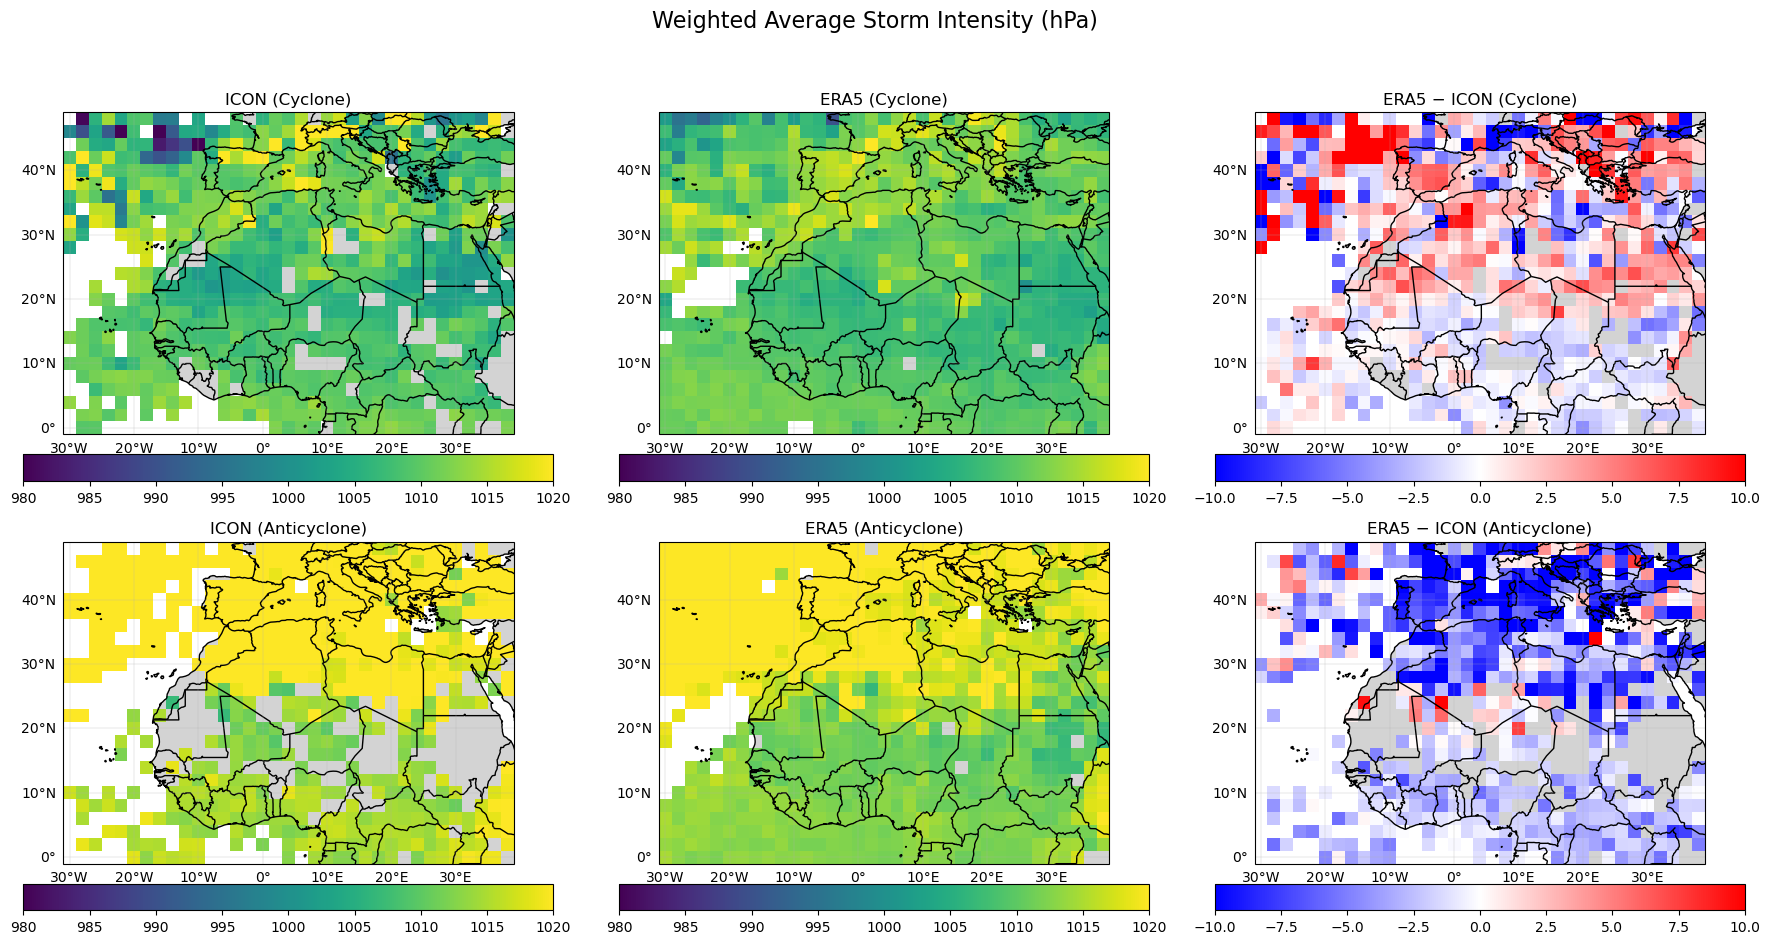

In [33]:
vmin_list = [
    980,   
    980,     
    -10                                                   
]
vmax_list = [
    1020,
    1020,
    10
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={"projection": ccrs.PlateCarree()})
titles = ["ICON", "ERA5", "ERA5 − ICON"]
data_c = [amp_icon_c, amp_era5_c, amp_diff_c]
data_a = [amp_icon_a, amp_era5_a, amp_diff_a]

for i in range(3):
    for j, data in enumerate([data_c, data_a]):
        ax = axes[j, i]
        cmap = "viridis" if i < 2 else "bwr"
        
        vmin = vmin_list[i]
        vmax = vmax_list[i]
        
        im = ax.pcolormesh(lon_grid, lat_grid, data[i], cmap=cmap, shading="auto",
                           vmin=vmin, vmax=vmax)
        
        ax.set_title(f"{titles[i]} ({'Cyclone' if j==0 else 'Anticyclone'})", fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='white')
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.2)
        gl.top_labels = gl.right_labels = False
        
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)

plt.suptitle("Weighted Average Storm Intensity (hPa)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("/work/ab0995/a270284/Weighted Average Storm Intensity.png", dpi=300, bbox_inches='tight')
plt.show()

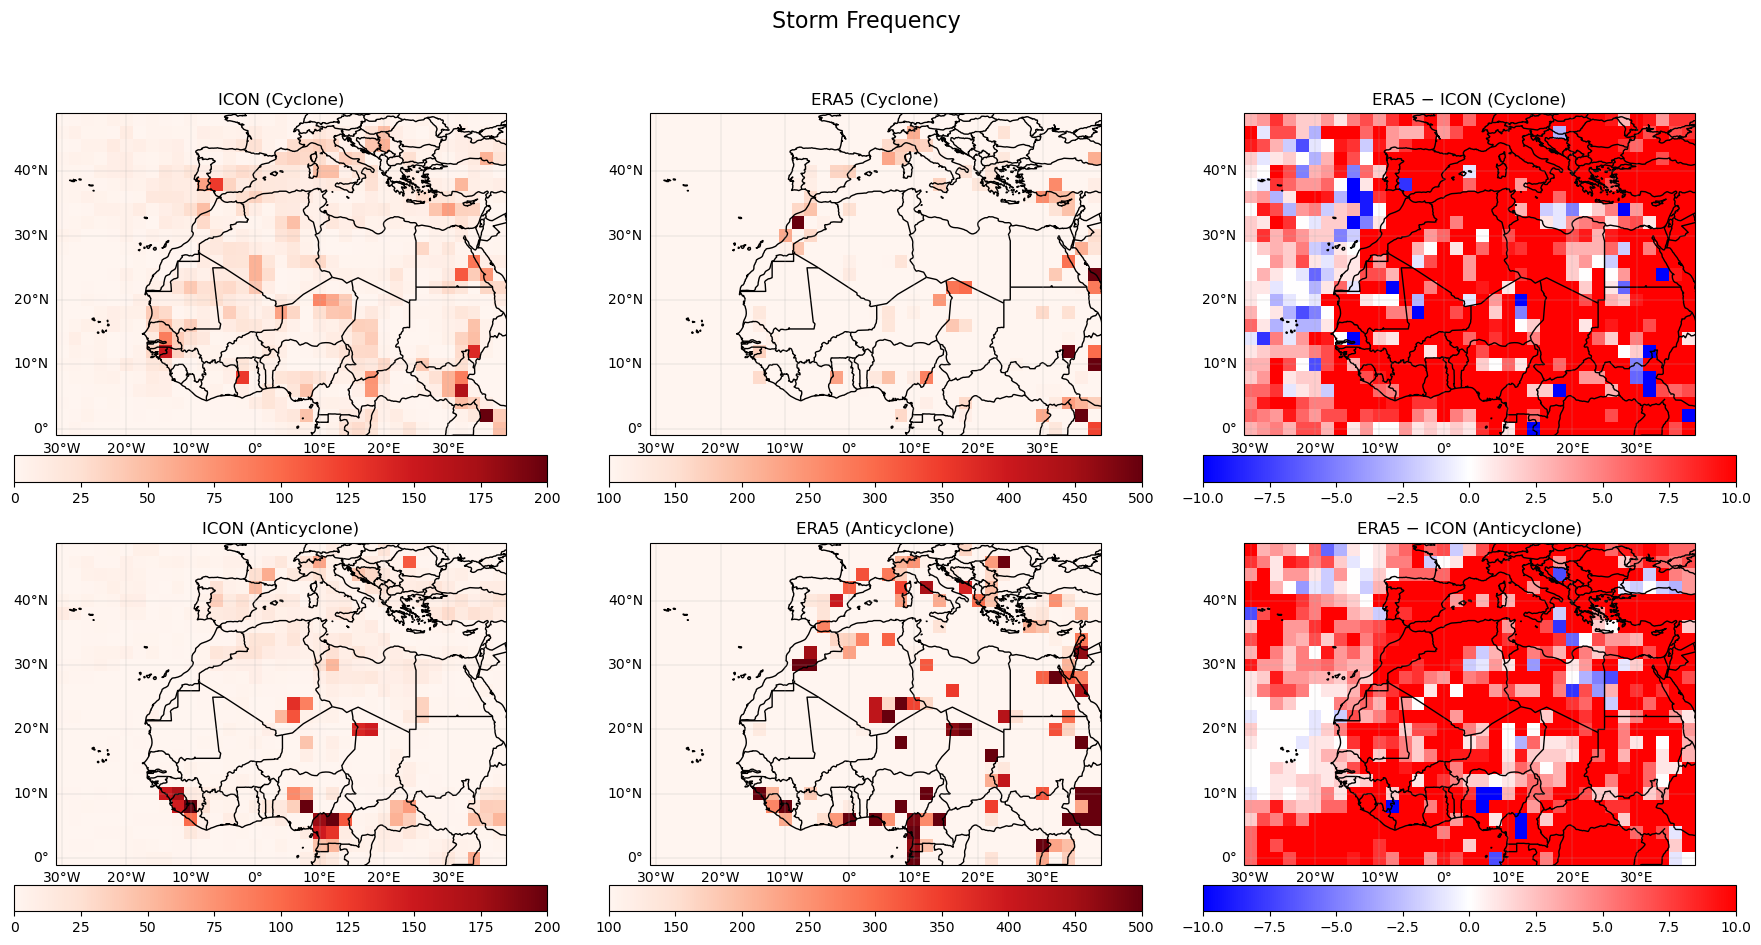

In [34]:
vmin_list_freq = [
    0,     
    100,     
    -10                                                 
]
vmax_list_freq = [
    200,
    500,
    10
]


fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={"projection": ccrs.PlateCarree()})
titles = ["ICON", "ERA5", "ERA5 − ICON"]
data_c = [count_icon_c, count_era5_c, count_diff_c]
data_a = [count_icon_a, count_era5_a, count_diff_a]

for i in range(3):
    for j, data in enumerate([data_c, data_a]):
        ax = axes[j, i]
        cmap = "Reds" if i < 2 else "bwr"
        
        vmin = vmin_list_freq[i]
        vmax = vmax_list_freq[i]

        im = ax.pcolormesh(lon_grid, lat_grid, data[i], cmap=cmap, shading="auto",
                           vmin=vmin, vmax=vmax)
        
        ax.set_title(f"{titles[i]} ({'Cyclone' if j == 0 else 'Anticyclone'})", fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='white')
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.2)
        gl.top_labels = gl.right_labels = False
        
 
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)

plt.suptitle("Storm Frequency", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("/work/ab0995/a270284/Storm Frequency.png", dpi=300, bbox_inches='tight')
plt.show()
